In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Step 1: 导入数据

In [3]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_case4_norm_10.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_ctrl4_norm_10.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

print(data_case.shape)
print(data_ctrl.shape)

(143, 10)
(143, 10)


In [4]:
data_case.head()

,SDPR,VWA2,TTC39A,PAX2,F3,TRIM59,CABP1,PLEKHN1,NETO2,ATP1B1
GSM1823850,0.52,0.38,0.55,0.30,0.58,0.35,0.29,0.35,0.50,0.70
GSM1823851,0.62,0.34,0.29,0.24,0.63,0.28,0.34,0.28,0.34,0.61
GSM1823852,0.63,0.36,0.32,0.35,0.63,0.34,0.41,0.41,0.33,0.58
GSM1823853,0.41,0.40,0.46,0.39,0.59,0.48,0.28,0.45,0.42,0.77
GSM1823854,0.43,0.44,0.45,0.32,0.64,0.39,0.30,0.42,0.53,0.81


In [5]:
data_ctrl.head()

,SDPR,VWA2,TTC39A,PAX2,F3,TRIM59,CABP1,PLEKHN1,NETO2,ATP1B1
GSM1823702,0.64,0.42,0.35,0.27,0.64,0.37,0.43,0.34,0.40,0.68
GSM1823703,0.50,0.41,0.30,0.28,0.54,0.28,0.31,0.32,0.42,0.79
GSM1823704,0.62,0.37,0.37,0.25,0.67,0.28,0.45,0.35,0.38,0.64
GSM1823705,0.71,0.38,0.36,0.24,0.72,0.33,0.48,0.37,0.39,0.66
GSM1823706,0.64,0.41,0.42,0.28,0.68,0.39,0.40,0.39,0.46,0.76


# Step 2: 建立模型

In [17]:
data_case.index = data_ctrl.index = range(143)

In [18]:
K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

This data have 143 samples and each has 10 features
[[-0.12 -0.05  0.2  ...,  0.01  0.1   0.02]
 [ 0.12 -0.07 -0.01 ..., -0.04 -0.08 -0.19]
 [ 0.02 -0.02 -0.05 ...,  0.06 -0.05 -0.06]
 ..., 
 [-0.07 -0.04 -0.01 ..., -0.02  0.03  0.08]
 [-0.37 -0.02  0.13 ...,  0.06  0.09  0.02]
 [-0.08  0.04  0.06 ...,  0.01 -0.02 -0.02]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [19]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1 = pm.sample(100, step, start)
    #trace_s = pm.sample(2000)
    

logp = 95.19, ||grad|| = 27.852: 100%|██████████| 155/155 [00:00<00:00, 1630.45it/s]           
Assigned BinaryGibbsMetropolis to r
100%|█████████▉| 597/600 [00:03<00:00, 171.86it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.886640492772, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 600/600 [00:03<00:00, 171.69it/s]


In [20]:
with model:
    trace_s = pm.sample(50000, trace=trace_1)

Assigned NUTS to w_c_log__
Assigned NUTS to w_d_log__
Assigned NUTS to b_sigma
Assigned NUTS to w_logodds__
Assigned BinaryGibbsMetropolis to r
Assigned NUTS to alpha
100%|█████████▉| 50486/50500 [04:35<00:00, 182.99it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3539 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 50500/50500 [04:35<00:00, 183.01it/s]


In [30]:
np.save(arr=trace_s, file="GEO_trace_s")

[]

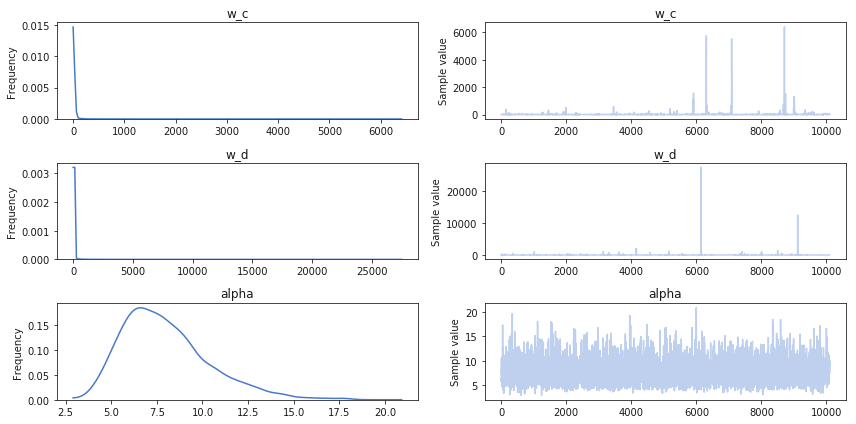

In [22]:
trace_10 = trace_s
chain_10 = trace_10[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain_10, varnames)
plt.plot()

In [23]:
pm.df_summary(chain_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_c,20.84,167.08,4.87,0.05,40.42
w_d,26.88,341.49,5.84,0.10,61.73
alpha,8.02,2.42,0.06,4.07,12.96


(10100, 10)
[ 0.5   0.48  0.49  0.48  0.5   0.48  0.5   0.48  0.48  0.48]


[]

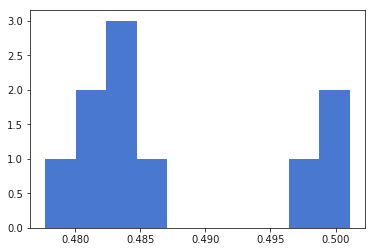

In [24]:
r_features = chain_10['r']
print(r_features.shape)

var_importance = r_features.mean(axis=0)
print(var_importance)
plt.hist(var_importance)
plt.plot()

In [25]:
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance

df_result = df_result.sort_values('importance', ascending=False)
df_result

,features,importance
6,CABP1,0.50
0,SDPR,0.50
4,F3,0.50
2,TTC39A,0.49
1,VWA2,0.48
3,PAX2,0.48
7,PLEKHN1,0.48
9,ATP1B1,0.48
5,TRIM59,0.48
8,NETO2,0.48


In [26]:
df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output2/6_bayesian_10.csv",index=False)

## Top 50

In [28]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_case4_norm_50.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_ctrl4_norm_50.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index = range(143)

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))


data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(143, 50)
(143, 50)
This data have 143 samples and each has 50 features
[[ -1.23e-01  -4.67e-02   2.02e-01 ...,   1.33e-01  -7.60e-02  -1.55e-01]
 [  1.22e-01  -7.05e-02  -8.89e-03 ...,  -1.91e-01   4.79e-02   5.72e-02]
 [  1.68e-02  -1.79e-02  -4.61e-02 ...,   2.74e-04   7.34e-02  -5.23e-02]
 ..., 
 [ -6.69e-02  -4.07e-02  -6.09e-03 ...,  -4.46e-02   4.01e-02  -9.63e-02]
 [ -3.68e-01  -1.80e-02   1.31e-01 ...,   1.19e-01   2.48e-01  -3.04e-01]
 [ -8.34e-02   3.72e-02   5.89e-02 ...,  -2.98e-03   1.20e-02  -5.84e-02]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  

In [29]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_50 = pm.sample(50000, step, start)

logp = 455.93, ||grad|| = 1.8471e+09: 100%|██████████| 77/77 [00:00<00:00, 2178.58it/s]    
Assigned BinaryGibbsMetropolis to r
100%|██████████| 50500/50500 [08:49<00:00, 95.32it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.681489023014, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 8329 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



In [31]:
np.save(arr=trace_50, file="GEO_trace_50")

[]

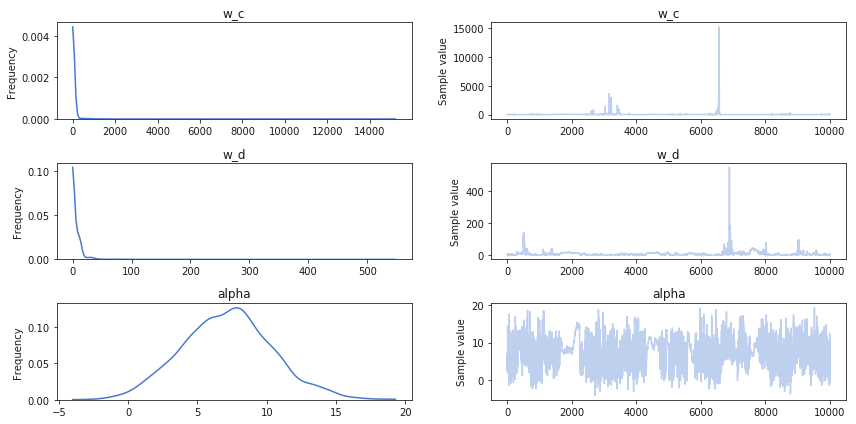

In [32]:
trace_50 = trace_50
chain_50 = trace_50[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain_50, varnames)
plt.plot()

In [34]:
r_features = chain_50['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output2/6_bayesian_50.csv",index=False)

df_result

,features,importance
14,A_33_P3236661,0.65
40,A_33_P3332581,0.65
37,PDE9A,0.65
33,DEFA3,0.65
38,CETP,0.65
11,MEOX1,0.65
32,HBB,0.65
0,SDPR,0.65
49,ADH1C,0.65
26,A_33_P3284621,0.65


# Top100

In [36]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_case4_norm_100.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_ctrl4_norm_100.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index = range(143)

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(143, 100)
(143, 100)
This data have 143 samples and each has 100 features
[[ -1.23e-01  -4.67e-02   2.02e-01 ...,   9.24e-02   1.04e-02  -2.43e-01]
 [  1.22e-01  -7.05e-02  -8.89e-03 ...,  -5.73e-02  -2.47e-02   5.84e-02]
 [  1.68e-02  -1.79e-02  -4.61e-02 ...,  -4.57e-02   5.83e-02  -6.63e-02]
 ..., 
 [ -6.69e-02  -4.07e-02  -6.09e-03 ...,  -6.66e-02   2.10e-04  -8.82e-02]
 [ -3.68e-01  -1.80e-02   1.31e-01 ...,   7.19e-02  -3.74e-02  -2.85e-01]
 [ -8.34e-02   3.72e-02   5.89e-02 ...,  -3.08e-02   3.27e-02  -6.83e-02]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1

In [38]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_100 = pm.sample(50000, step, start)
    
np.save(arr=trace_100, file="GEO_trace_100")

logp = -1.4803e+05, ||grad|| = 3.8899e+07: 100%|██████████| 20/20 [00:00<00:00, 2300.58it/s]  
Assigned BinaryGibbsMetropolis to r
100%|█████████▉| 50499/50500 [17:25<00:00, 48.28it/s]/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3460 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 50500/50500 [17:25<00:00, 48.28it/s]


[]

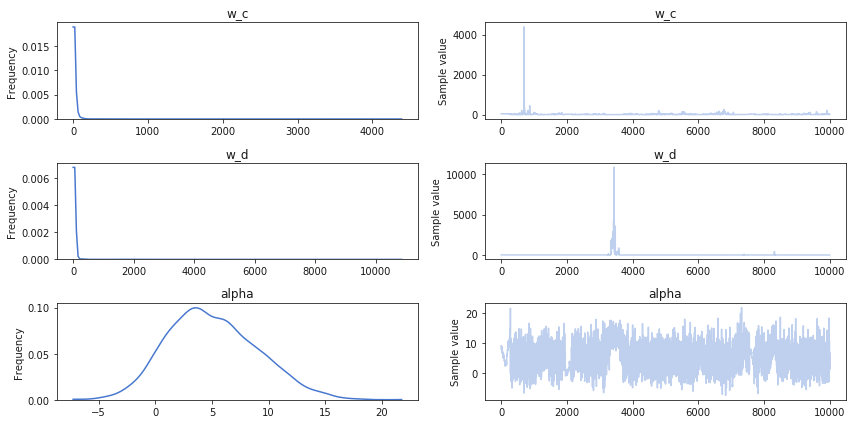

In [39]:
trace = trace_100
chain = trace[40000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

In [40]:
r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output2/6_bayesian_100.csv",index=False)

df_result

,features,importance
37,PDE9A,0.69
51,MMP27,0.69
89,A_33_P3398386,0.69
0,SDPR,0.69
57,AVPR2,0.69
61,CPA1,0.69
6,CABP1,0.69
36,C21orf90,0.69
91,RGN,0.69
50,TDRD10,0.69


# Top1000

In [41]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_case4_norm_1000.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input2/GEO-input-norm/input_data_ctrl4_norm_1000.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

data_case.index = data_ctrl.index = range(143)

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

(143, 1000)
(143, 1000)
This data have 143 samples and each has 1000 features
[[-0.12 -0.05  0.2  ..., -0.06  0.08  0.15]
 [ 0.12 -0.07 -0.01 ...,  0.06 -0.11  0.08]
 [ 0.02 -0.02 -0.05 ...,  0.03  0.02  0.1 ]
 ..., 
 [-0.07 -0.04 -0.01 ...,  0.03  0.02  0.01]
 [-0.37 -0.02  0.13 ...,  0.16  0.1   0.14]
 [-0.08  0.04  0.06 ...,  0.01 -0.    0.  ]]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


logp = 11,494, ||grad|| = 3.5297e+08: 100%|██████████| 56/56 [00:00<00:00, 1136.73it/s]       
Assigned BinaryGibbsMetropolis to r
100%|██████████| 100500/100500 [17:21:31<00:00,  1.61it/s] /home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.941997269564, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/lsen/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3403 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self

ValueError: Length of values does not match length of index

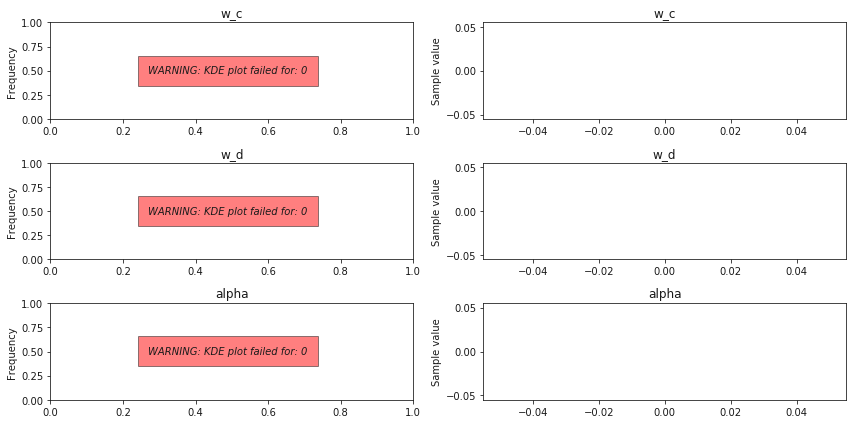

In [42]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1000 = pm.sample(100000, step, start)
    
np.save(arr=trace_1000, file="GEO_trace_1000")

,features,importance
745,CES1,0.61
723,RGS7BP,0.61
979,PKD1L2,0.61
105,LOC644662,0.61
334,HBM,0.61


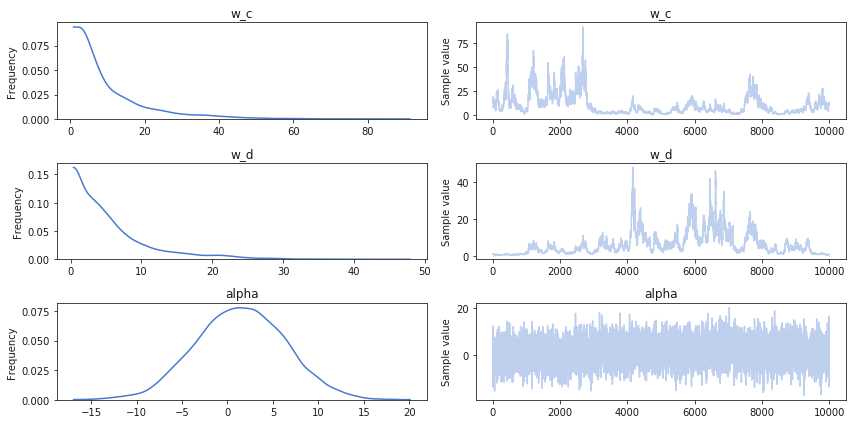

In [44]:
trace = trace_1000
chain = trace[90000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)
df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output2/6_bayesian_1000.csv",index=False)

df_result.head()

# Top 1500

In [ ]:
data_case = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_case4_1500.csv", index_col=0)
data_ctrl = pd.read_csv("/home/lsen/Data/CODE/feature_selection/_data/input/input_data_ctrl4_1500.csv", index_col=0)

data_case = data_case.transpose()
data_ctrl = data_ctrl.transpose()

print(data_case.shape)
print(data_ctrl.shape)

K = data_case.shape[1]
I = data_case.shape[0]
print("This data have %d samples and each has %d features" % (I, K))

data_x = np.array(data_case - data_ctrl)
data_y = np.ones(I)

print(data_x)
print(data_y)

In [ ]:
with pm.Model() as model:
    # hyper-priors
    w_c = pm.HalfCauchy('w_c', beta=5)
    w_d = pm.HalfCauchy('w_d', beta=5)
    
    beta_sigma = pm.Normal('b_sigma', mu=0, sd=5)
    beta_deta0 = 1
    
    # prioris
    w = pm.Beta('w', alpha=w_c, beta=w_d, shape=K)
    r = pm.Bernoulli('r', w, shape=K)
    
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = r*beta_sigma + (1-r)*beta_deta0
    
    # predictor
    mu = alpha + pm.math.dot(data_x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    
    # define likelihood
    y = pm.Bernoulli('y', p=theta, observed=data_y)
    
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1000 = pm.sample(100000, step, start)
    
np.save(arr=trace_1500, file="trace_1500")

In [ ]:
trace = trace_1500
chain = trace[90000:]
varnames = ['w_c', 'w_d','alpha']
pm.traceplot(chain, varnames)
plt.plot()

In [ ]:
r_features = chain['r']
var_importance = r_features.mean(axis=0)
df_result = pd.DataFrame()
df_result['features'] = data_case.columns.values
df_result['importance'] = var_importance
df_result = df_result.sort_values('importance', ascending=False)

df_result.to_csv(path_or_buf="/home/lsen/Data/CODE/feature_selection/_data/output/6_bayesian_1500.csv",index=False)

df_result